# `descwl-shear-sims` Tutorial

We'll learn how to make simple simulations for testing shear algorithms using the same package that was used to verify `metadetect` by the DESC. 

## Software Installation

### NERSC

For those with access to NERSC, there is a file that can be sourced which should setup a working jupyter environment for you:


```bash
source /pscratch/sd/b/beckermr/install-descwl-shear-sims-kernel.sh
```

Then you can log into jupyter hub and launch a notebook using the `descwl-shear-sims` kernel.


### Local

If you'd like to do this tutorial on your own machine, you'll need `conda` installed locally with `conda-forge` as your highest priority channel. You'll also likely want to install and use `mamba` instead of `conda` via 


```bash
conda install -n base mamba
```

Then follow these steps

```bash
mamba create -n sims stackvana ipykernel wget  # this command takes a while, only install wget if you don't have it
conda activate sims
git clone https://github.com/LSSTDESC/descwl-shear-sims.git
pushd descwl-shear-sims
mamba install --file requirements.txt
pip install --no-deps --no-build-isolation .
popd
```

You'll also need to grab some simulation data:

```bash
wget https://www.cosmo.bnl.gov/www/esheldon/data/catsim.tar.gz
tar xvfz catsim.tar.gz
export CATSIM_DIR=`pwd`/catsim
```

At this point you should be able import both the DM stack and the simulation code:


```bash
python -c "import lsst.afw; import descwl_shear_sims"  # this one can take a while too
```



# Making a Simulation

We'll follow two of the examples that are included with the package. 

First, we'll make a simple grid simulation. Then, we'll do something complicated.

## Grid Simulation

In [1]:
import os
import numpy as np

import lsst.afw.image as afw_image
import lsst.afw.geom as afw_geom
from descwl_shear_sims.galaxies import make_galaxy_catalog
from descwl_shear_sims.stars import make_star_catalog
from descwl_shear_sims.psfs import make_ps_psf, make_fixed_psf
from descwl_shear_sims.sim import make_sim, get_se_dim

# for plotting later
import matplotlib.pyplot as plt

%matplotlib inline

We'll start by seeding the RNG and setting some basic parameters.

In [2]:
seed = 74321
rng = np.random.RandomState(seed)

coadd_dim = 351
psf_dim = 51
bands = ['r', 'i']

The default galaxies are round, exponential profiles with a fixed half-light radius. We use a gaussian PSF as well. This configuration is useful for testing shear codes quickly.

Other possible options can be found by looking through doc strings and the source code.

```python
>>> print(make_galaxy_catalog.__doc__)
    rng: numpy.random.RandomState
        Numpy random state
    gal_type: string
        'fixed', 'varying' or 'wldeblend'
    coadd_dim: int
        Dimensions of coadd
    buff: int, optional
        Buffer around the edge where no objects are drawn.  Ignored for
        layout 'grid'.  Default 0.
    layout: string, optional
        'grid' or 'random'.  Ignored for gal_type "wldeblend", otherwise
        required.
    gal_config: dict or None
        Can be sent for fixed galaxy catalog.  See DEFAULT_FIXED_GAL_CONFIG
        for defaults mag, hlr and morph
    sep: float, optional
        Separation of pair in arcsec for layout='pair'
```

In [3]:
# this makes a grid of fixed exponential galaxies
# with default properties. One exposure per band
galaxy_catalog = make_galaxy_catalog(
    rng=rng,
    gal_type='fixed',
    coadd_dim=coadd_dim,
    buff=30,
    layout='grid',
)

# gaussian psf
psf = make_fixed_psf(psf_type='gauss')

Now let's make the simulation!

In [4]:
# generate simulated data, see below for whats in this dict
data = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    coadd_dim=coadd_dim,
    psf_dim=psf_dim,
    bands=bands,
    g1=0.02,
    g2=0.00,
    psf=psf,
    dither=True,
    rotate=True,
    star_bleeds=False
)

The `data` is a dictionary with various keys:

   - `band_data`: a dict, keyed by band name, with values that are a list of exps
   - `coadd_wcs`: is a DM wcs for use in coadding
   - `psf_dims`: is the psf dim we sent in (psf_dim, psf_dim)
   - `coadd_dims`: shape of the coadd image (dim, dim)
   - `coadd_bbox`: is an lsst Box2I, for use in coadding
   - `bright_info`: is a structured array with position and mask info for bright objects
   - `se_wcs`: list of WCS for each single epoch image
   
Yay! Let's make some plots.

Text(0, 0.5, 'row [pixels]')

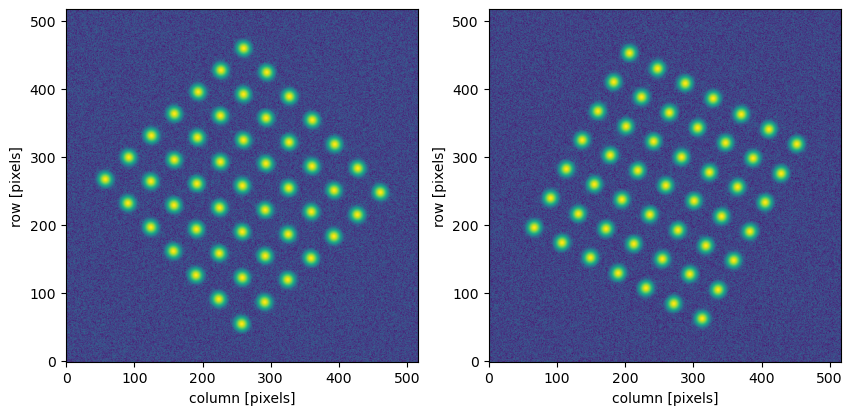

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

exp = data["band_data"]["r"][0]
axs[0].imshow(
    np.arcsinh(exp.image.array / np.sqrt(exp.variance.array)), 
    cmap="viridis",
    origin="lower",
)
axs[0].set_xlabel("column [pixels]")
axs[0].set_ylabel("row [pixels]")

exp = data["band_data"]["i"][0]
axs[1].imshow(
    np.arcsinh(exp.image.array / np.sqrt(exp.variance.array)), 
    cmap="viridis",
    origin="lower",
)
axs[1].set_xlabel("column [pixels]")
axs[1].set_ylabel("row [pixels]")

## Complicated Simulation

In [37]:
seed = 76
rng = np.random.RandomState(seed)

dither = True
rotate = False
coadd_dim = 351
psf_dim = 51
bands = ['r', 'i']
buff = 30

In [38]:
# this makes WeakLensingDeblending galaxies
galaxy_catalog = make_galaxy_catalog(
    rng=rng,
    gal_type='wldeblend',
    coadd_dim=coadd_dim,
    buff=buff,
    layout='random',
)

# stars with the high density so we get some
# bright ones
star_config = {'density': 100}
star_catalog = make_star_catalog(
    rng=rng,
    coadd_dim=coadd_dim,
    buff=buff,
    star_config=star_config,
)

# power spectrum psf
se_dim = get_se_dim(coadd_dim=coadd_dim, rotate=rotate, dither=dither)
psf = make_ps_psf(rng=rng, dim=se_dim)

In [39]:
# this takes a moment
data = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    star_catalog=star_catalog,
    coadd_dim=coadd_dim,
    psf_dim=psf_dim,
    bands=bands,
    g1=0.02,
    g2=0.00,
    psf=psf,
    dither=dither,
    rotate=rotate,
    star_bleeds=False,
    draw_stars=False
)

Text(0, 0.5, 'row [pixels]')

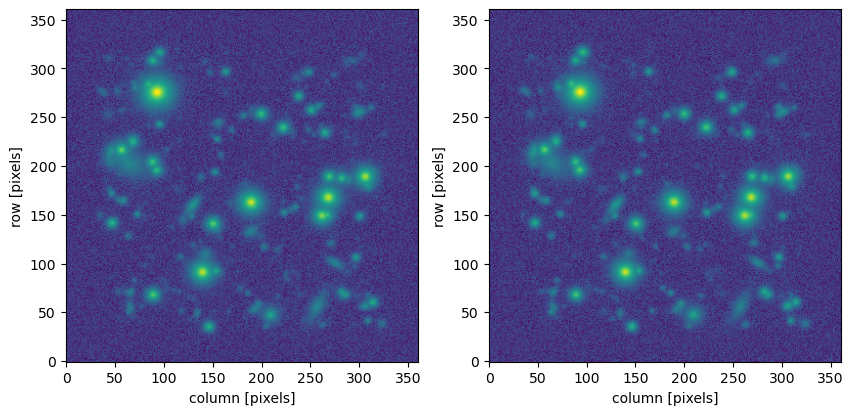

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

exp = data["band_data"]["r"][0]
axs[0].imshow(
    np.arcsinh(exp.image.array / np.sqrt(exp.variance.array)), 
    cmap="viridis",
    origin="lower",
)
axs[0].set_xlabel("column [pixels]")
axs[0].set_ylabel("row [pixels]")

exp = data["band_data"]["i"][0]
axs[1].imshow(
    np.arcsinh(exp.image.array / np.sqrt(exp.variance.array)), 
    cmap="viridis",
    origin="lower",
)
axs[1].set_xlabel("column [pixels]")
axs[1].set_ylabel("row [pixels]")

## You can make your custom simulations as well!

For example, we can adjust the galaxies in ways that are not hard coded like this.

In [35]:
from descwl_shear_sims.shifts import get_shifts, get_pair_shifts
import galsim


class CustomGalaxyCatalog(object):
    """Like fixed but with size variation"""
    def __init__(self, *, rng, coadd_dim, layout, buff=0):
        self.gal_type = 'fixed'
        self.mag = 17

        self.shifts_array = get_shifts(
            rng=rng,
            coadd_dim=coadd_dim,
            buff=buff,
            layout=layout,
        )
        
        self.rng = rng

    def __len__(self):
        return len(self.shifts_array)

    def get_objlist(self, *, survey):
        """
        get a list of galsim objects

        Parameters
        ----------
        band: string
            Get objects for this band.  For the fixed
            catalog, the objects are the same for every band

        Returns
        -------
        [galsim objects], [shifts]
        """

        flux = survey.get_flux(self.mag)

        sarray = self.shifts_array
        objlist = []
        shifts = []
        redshifts = []
        for i in range(len(self)):
            objlist.append(self._get_galaxy(flux))
            shifts.append(galsim.PositionD(sarray['dx'][i], sarray['dy'][i]))
            redshifts.append(None)

        return objlist, shifts, redshifts

    def _get_galaxy(self, flux):
        hlr = self.rng.uniform() * (0.7-0.4) + 0.4
        g1, g2 = self.rng.uniform(size=2)*0.2 - 0.1
        gal = galsim.Exponential(half_light_radius=hlr, flux=flux).shear(g1=g1, g2=g2)
        return gal


In [36]:
seed = 74321
rng = np.random.RandomState(seed)

coadd_dim = 351
psf_dim = 51
bands = ['r', 'i']

galaxy_catalog = CustomGalaxyCatalog(rng=rng, coadd_dim=coadd_dim, layout="grid", buff=30)

# gaussian psf
psf = make_fixed_psf(psf_type='gauss')

# generate simulated data, see below for whats in this dict
data = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    coadd_dim=coadd_dim,
    psf_dim=psf_dim,
    bands=bands,
    g1=0.02,
    g2=0.00,
    psf=psf,
    dither=True,
    rotate=True,
)

Text(0, 0.5, 'row [pixels]')

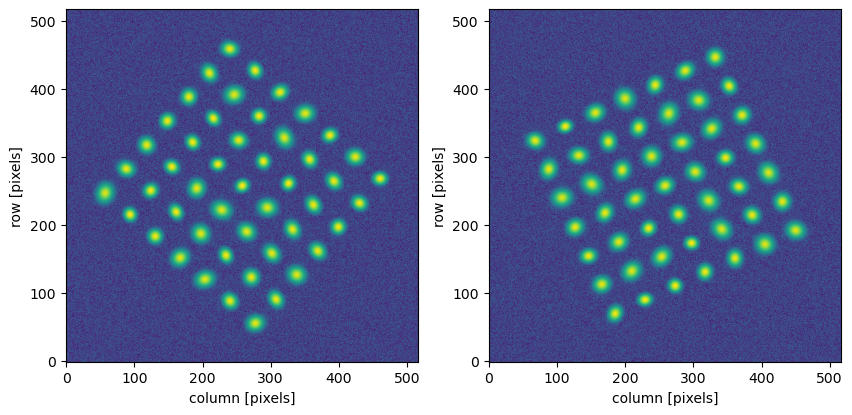

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

exp = data["band_data"]["r"][0]
axs[0].imshow(
    np.arcsinh(exp.image.array / np.sqrt(exp.variance.array)), 
    cmap="viridis",
    origin="lower",
)
axs[0].set_xlabel("column [pixels]")
axs[0].set_ylabel("row [pixels]")

exp = data["band_data"]["i"][0]
axs[1].imshow(
    np.arcsinh(exp.image.array / np.sqrt(exp.variance.array)), 
    cmap="viridis",
    origin="lower",
)
axs[1].set_xlabel("column [pixels]")
axs[1].set_ylabel("row [pixels]")

## How to: Metadetection courtesy of Erin Sheldon

In [41]:
import descwl_coadd
from descwl_coadd import make_coadd_nowarp
from lsst.afw.image import ExposureF

In [42]:
data['psf_dims']

(51, 51)

In [43]:
data['band_data']['i']

In [44]:
result= make_coadd_nowarp(data['band_data']['i'][0],
                          data['psf_dims'],
                          np.random.RandomState(1),
                          False)

In [45]:
result

{'nkept': 1,
 'exp_info': array([(0, 0, 3.06934416e-05, 0.)],
       dtype=[('exp_id', '<i8'), ('flags', '<i4'), ('maskfrac', '<f8'), ('weight', '<f8')]),
 'coadd_exp': <lsst.afw.image._exposure.ExposureF at 0x7fa189cded30>,
 'coadd_noise_exp': <lsst.afw.image._exposure.ExposureF at 0x7fa189d50230>,
 'coadd_psf_exp': <lsst.afw.image._exposure.ExposureF at 0x7fa189e0c2b0>,
 'coadd_mfrac_exp': <lsst.afw.image._exposure.ExposureF at 0x7fa18af0e570>}

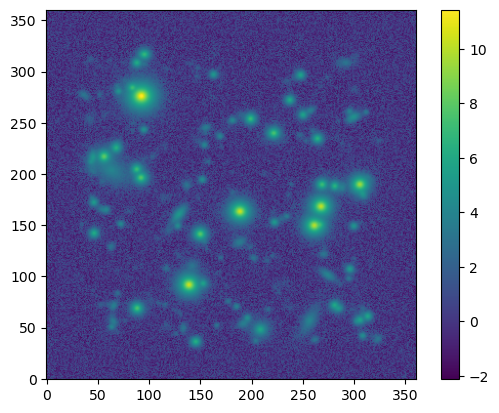

In [46]:
plt.imshow(np.arcsinh(result['coadd_exp'].image.array / np.sqrt(result['coadd_exp'].variance.array)), origin='lower')
plt.colorbar()

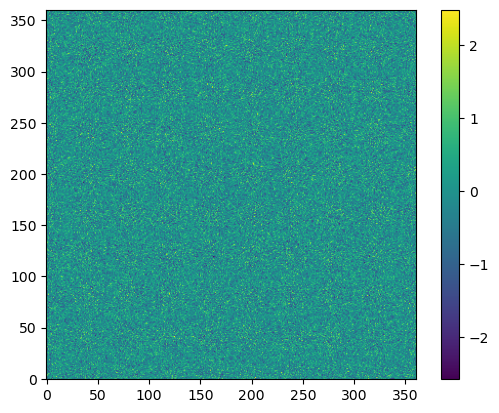

In [47]:
plt.imshow(result['coadd_noise_exp'].image.array, origin='lower')
plt.colorbar()

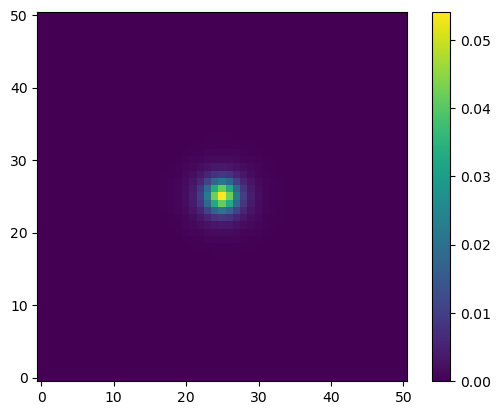

In [48]:
plt.imshow(result['coadd_psf_exp'].image.array, origin='lower')
plt.colorbar()

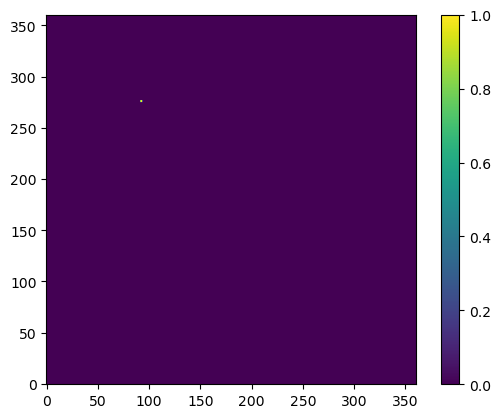

In [49]:
plt.imshow(result['coadd_mfrac_exp'].image.array, origin='lower')
plt.colorbar()

In [50]:
result_i= make_coadd_nowarp(data['band_data']['i'][0],
                          data['psf_dims'],
                          np.random.RandomState(1),
                          False)
result_r= make_coadd_nowarp(data['band_data']['r'][0],
                          data['psf_dims'],
                          np.random.RandomState(1),
                          False)

In [51]:
import metadetect
from metadetect.lsst.util import extract_multiband_coadd_data
from metadetect.lsst.metadetect import run_metadetect

In [52]:
multiband_coadd_obj = extract_multiband_coadd_data([result_i])

In [53]:
multiband_coadd_obj

{'mbexp': <MultibandExposure, filters=('i',), bbox=Box2I(corner=Point2I(0, 0), dimensions=Extent2I(361, 361))>,
 'noise_mbexp': <MultibandExposure, filters=('i',), bbox=Box2I(corner=Point2I(0, 0), dimensions=Extent2I(361, 361))>,
 'mfrac_mbexp': <MultibandExposure, filters=('i',), bbox=Box2I(corner=Point2I(0, 0), dimensions=Extent2I(361, 361))>,
 'ormasks': [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32)]}

In [54]:
r = run_metadetect(mbexp = multiband_coadd_obj['mbexp'],
                   noise_mbexp = multiband_coadd_obj['noise_mbexp'],
                   rng = np.random.RandomState(1),
                   mfrac_mbexp = multiband_coadd_obj['mfrac_mbexp'],
                   ormasks = multiband_coadd_obj['ormasks'],
                   config=None,
                   show=False)

In [55]:
r.keys()

dict_keys(['noshear', '1p', '1m'])

In [56]:
r['noshear'].dtype.fields


mappingproxy({'wmom_flags': (dtype('int32'), 0),
              'wmom_psf_flags': (dtype('int32'), 4),
              'wmom_psf_g': (dtype(('<f8', (2,))), 8),
              'wmom_psf_T': (dtype('float64'), 24),
              'wmom_obj_flags': (dtype('int32'), 32),
              'wmom_s2n': (dtype('float64'), 36),
              'wmom_g': (dtype(('<f8', (2,))), 44),
              'wmom_g_cov': (dtype(('<f8', (2, 2))), 60),
              'wmom_T': (dtype('float64'), 92),
              'wmom_T_flags': (dtype('int32'), 100),
              'wmom_T_err': (dtype('float64'), 104),
              'wmom_T_ratio': (dtype('float64'), 112),
              'wmom_band_flux_flags': (dtype('int32'), 120),
              'wmom_band_flux': (dtype('float64'), 124),
              'wmom_band_flux_err': (dtype('float64'), 132),
              'shear_bands': (dtype('<U6'), 140),
              'stamp_size': (dtype('int32'), 164),
              'row0': (dtype('int32'), 168),
              'col0': (dtype('int32'), 172)

(array([ 2.,  1.,  4.,  7., 11., 47., 26., 12.,  5.,  3.]),
 array([-0.70065998, -0.57947134, -0.45828269, -0.33709405, -0.2159054 ,
        -0.09471676,  0.02647189,  0.14766053,  0.26884918,  0.39003782,
         0.51122647]),
 <BarContainer object of 10 artists>)

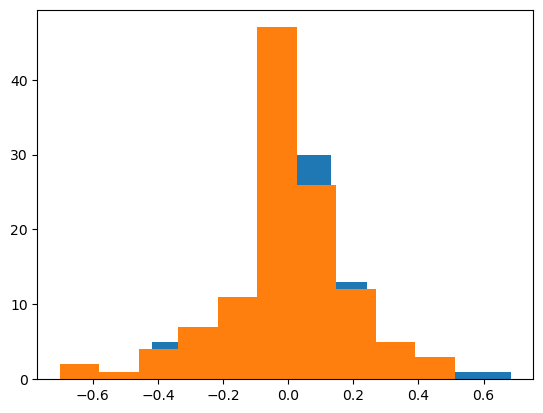

In [57]:
plt.hist(r['1p']['wmom_g'][:,0].ravel())
plt.hist(r['1p']['wmom_g'][:,1].ravel())